### TIME SERIES ANALYSIS 
Time series data is a series of data collected over a period of time. Time series analysis is a technique for analyzing ad extracting meaningful information from the time series data. the main objective of time series analysis is to forecast the future values.

### OVERVIEW OF THE DATA SET
This dataset contains 5 years of store-item sales data for 50 different items at 10 different stores.

### OUR TASK
Our task is to predict 3 months of sales for 50 different items at 10 different stores. 

In [51]:
# importing all the necessary library for the analysis
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from matplotlib.dates import date2num
import statsmodels.api as sm
import seaborn as sns
import lightgbm as lgb
import warnings
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error,r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
warnings.filterwarnings('ignore')

In [52]:
# loading the dataset
df = pd.read_csv('C:/Users/lenovo/Downloads/train 2.csv', parse_dates=['date'])
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


#### EXPLORATORY DATA ANALYSIS

In [53]:
def explore_data(data):
    
    print(data.head(5))
    print('####################### INFO ###################')
    print(data.info())
    print('####################### SHAPE ###################')
    print(f'rows = {df.shape[0]}')
    print(f'columns = {df.shape[1]}')
    print('####################### TYPES ###################')
    print(data.dtypes)    
    print('####################### NA ###################')
    print(data.isnull().sum())
    print('####################### QUANTILES ###################')
    print(data.quantile([0.2,0.10,0.25,0.50,0.60,0.75,0.99]).T)
    print('####################### NUMBER OF ITEMS ###################')
    print("number of stores =",data.store.nunique(),' number of items =', data.item.nunique())
    
    
    
        
explore_data(df)



        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
####################### INFO ###################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None
####################### SHAPE ###################
rows = 913000
columns = 4
####################### TYPES ###################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
####################### NA ###################
date     0
store    0
item 

In [54]:
## Print the first date and last date of the dataset
print('first date=',df['date'].min(), 'last date=',df['date'].max())

first date= 2013-01-01 00:00:00 last date= 2017-12-31 00:00:00


In [55]:
#Highest sale value among all the sales
df[df["sales"] == df["sales"].max()]

,date,store,item,sales
259109,2017-07-02,2,15,231


In [56]:
## taking aggregate values for each item from each store
df.groupby(["store", "item"]).agg({"sales":['count','mean','min','max','std','sum','median']})

sales                                               
           count        mean min  max        std     sum median
store item                                                     
1     1     1826   19.971522   4   50   6.741022   36468   19.0
      2     1826   53.148959  13  115  15.005779   97050   52.0
      3     1826   33.208105   8   70  10.072529   60638   33.0
      4     1826   19.956188   4   43   6.640618   36440   20.0
      5     1826   16.612815   3   37   5.672102   30335   16.0
      6     1826   53.060789  17  104  14.826416   96889   52.0
      7     1826   52.783680  14  115  15.073838   96383   52.0
      8     1826   69.472070  24  137  18.751980  126856   68.5
      9     1826   46.504929  14   94  13.247496   84918   46.0
      10    1826   66.354326  16  131  18.283007  121163   65.0
      11    1826   63.217963  11  124  17.230417  115436   62.0
      12    1826   63.233844  21  133  17.636872  115465   62.0
      13    1826   76.159365  27  139  20.374852  139067   75.0
      14    1826   53.148959  20  107  14.769971   97050   52.0
      15    1826   79.680723  17  154  21.725799  145497   78.0
      16    1826   23.332421   5   55   7.614738   42605   23.0
      17    1826   29.972070   9   61   9.116824   54729   29.0
      18    1826   76.345564  28  155  21.053109  139407   75.0
      19    1826   36.676889  11   75  11.100620   66972   36.0
      20    1826   42.890471  11   87  12.181551   78318   42.0
      21    1826   36.176342   9   74  10.840796   66058   35.0
      22    1826   72.781490  25  143  19.808007  132899   72.0
      23    1826   26.469880   5   55   8.460734   48334   26.0
      24    1826   60.000000  18  121  16.642840  109560   59.0
      25    1826   72.736035  24  143  19.799388  132816   72.0
      26    1826   43.236035  12   96  12.848906   78949   43.0
      27    1826   20.050931   1   48   6.640278   36613   20.0
      28    1826   79.566813  32  155  21.460002  145289   79.0
      29    1826   63.086528  19  124  17.277086  115196   62.0
      30    1826   36.318182  13   72  10.938036   66317   36.0
      31    1826   53.008215  15  106  14.954009   96793   52.0
      32    1826   39.837897  13   81  11.464108   72744   39.0
      33    1826   62.755750  23  123  17.178149  114592   62.0
      34    1826   23.274918   5   48   7.499406   42500   23.0
      35    1826   59.495071  20  115  16.482759  108638   58.0
      36    1826   69.309967  24  151  19.170648  126560   68.0
      37    1826   26.424425   8   62   8.312726   48251   26.0
      38    1826   73.344469  19  150  19.948156  133927   72.0
      39    1826   39.694962  13   86  11.783459   72483   39.0
      40    1826   26.443593   7   57   8.208805   48286   26.0
      41    1826   20.002738   3   42   6.684883   36525   20.0
      42    1826   33.105696   7   71   9.623903   60451   33.0
      43    1826   46.242607  15   98  13.345104   84439   45.0
      44    1826   26.594195   7   58   8.364186   48561   26.0
      45    1826   72.720701  25  135  19.730340  132788   72.0
      46    1826   52.845016  15  109  14.932417   96495   52.0
      47    1826   19.814348   4   44   6.554391   36181   19.0
      48    1826   46.546002  13   94  13.416421   84993   45.0
      49    1826   26.461665   7   53   8.299193   48319   26.0
      50    1826   59.342826  19  111  16.380065  108360   59.0
2     1     1826   28.173604   6   58   8.681013   51445   28.0
      2     1826   75.316539  26  150  20.332268  137528   74.0
      3     1826   46.992333  16   94  13.546306   85808   46.0
      4     1826   28.234940   7   66   8.655292   51557   28.0
      5     1826   23.540526   3   50   7.757471   42985   23.0
      6     1826   74.945235  24  148  20.319213  136850   74.0
      7     1826   75.058598  28  139  20.456365  137057   74.0
      8     1826   99.090361  35  181  26.278864  180939   98.0
      9     1826   65.478094  21  127  18.191487  119563   65.0
      10    1826   94.097481  33  175  24.9

### VISUALIZATION

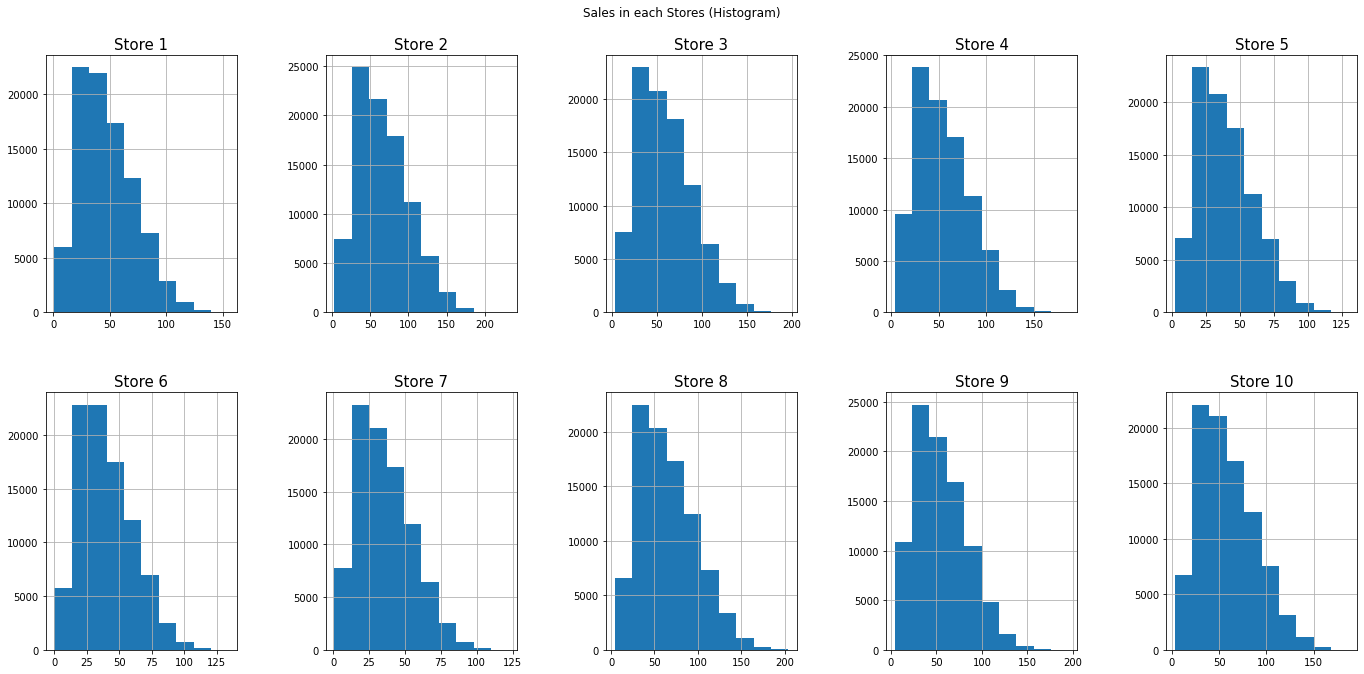

In [57]:
# sales in each store
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
for i in range(1, 11):
    if i < 6:
        df[df.store == i].sales.hist(ax=axes[0, i - 1])
        axes[0, i - 1].set_title("Store " + str(i), fontsize=15)

    else:
        df[df.store == i].sales.hist(ax=axes[1, i - 6])
        axes[1, i - 6].set_title("Store " + str(i), fontsize=15)
plt.tight_layout(pad=4.5)
plt.suptitle("Sales in each Stores (Histogram)");

In [58]:
##most profitable week, month and year

def profit(period="D", plot=False):

    df_perio = df.copy()
    df_perio.set_index("date", inplace=True)
    df_perio = df_perio.resample(period, closed='left').sum()
    df_perio.drop(columns=["store", "item"], inplace=True)
    df_perio["growth_rate"] = df_perio["sales"].pct_change() * 100
    df_perio.loc[[df_perio.index.min(), df_perio.index.max()], 'growth_rate'] = 0
    print(df_perio["sales"][df_perio["sales"] == df_perio["sales"].max()])

    if plot:
        df_perio["growth_rate"].plot(color="g", figsize=(12,8))
        plt.title(f"{period}'s growth rate")
        plt.xlabel("Date")
        plt.ylabel("Growth Rate %")
        plt.show()

    return df_perio

date
2017-07-23    264008
Freq: W-SUN, Name: sales, dtype: int64
date
2017-07-31    1178411
Freq: M, Name: sales, dtype: int64


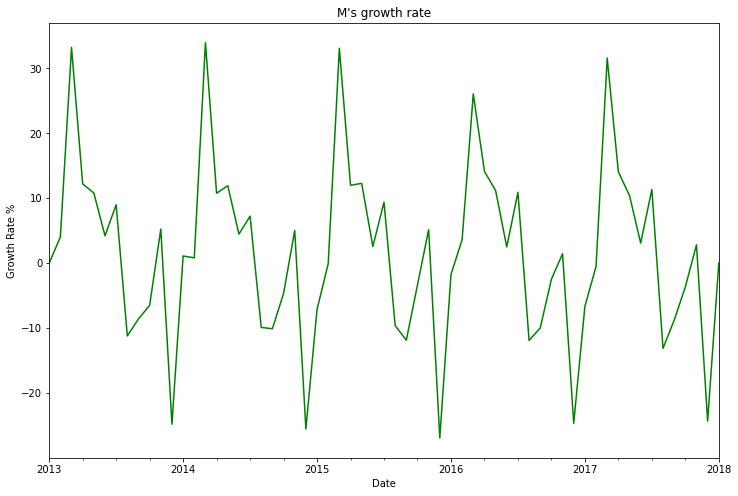

date
2017-12-31    10731112
Freq: A-DEC, Name: sales, dtype: int64


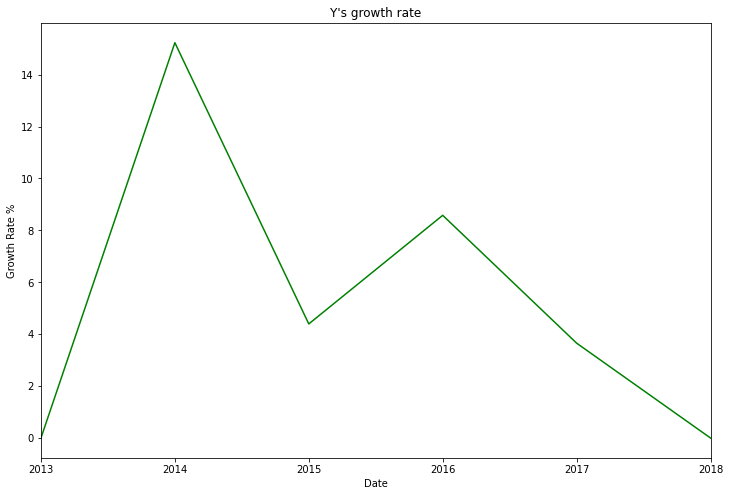

In [59]:
df_montly_sales=profit("W")
df_week = profit("M",True)
df_month = profit("Y", True)

<Figure size 432x288 with 0 Axes>

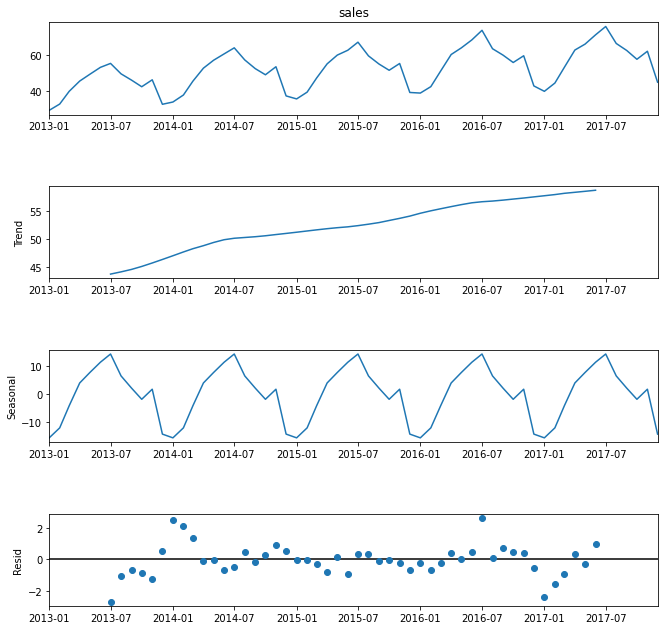

In [60]:

ds = df.set_index('date')
y = ds['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(10, 10)

* Sationarity: The dataset is not stationary. 

* Trend: The plot indicates the increasing trend over time.

* Seasonality: We can cleary see seasonality over there. repeating pattern is observed, moving upward till july. 

* Residuals: Residuals are decomposing around 0, so the series is additive.

#### FEATURE ENGINEERING

In [61]:
# Taking the copy of the dataframe
new_df = df.copy()

# Generating new columns for model development
def create_date_features(df):
    df['month'] = df.date.dt.month   
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['quarter'] = df['date'].dt.quarter
    return df

new_df = create_date_features(new_df)

In [62]:
new_df.head()

,date,store,item,sales,month,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter
0,2013-01-01,1,1,13,1,1,1,2013,0,1,0,1
1,2013-01-02,1,1,11,1,1,2,2013,0,0,0,1
2,2013-01-03,1,1,14,1,1,3,2013,0,0,0,1
3,2013-01-04,1,1,13,1,1,4,2013,1,0,0,1
4,2013-01-05,1,1,10,1,1,5,2013,1,0,0,1


In [63]:
new_df.dtypes

date              datetime64[ns]
store                      int64
item                       int64
sales                      int64
month                      int64
week_of_year               int64
day_of_week                int64
year                       int64
is_wknd                    int64
is_month_start             int32
is_month_end               int32
quarter                    int64
dtype: object

[Text(0.5, 1.0, 'MONTH VS SALES')]

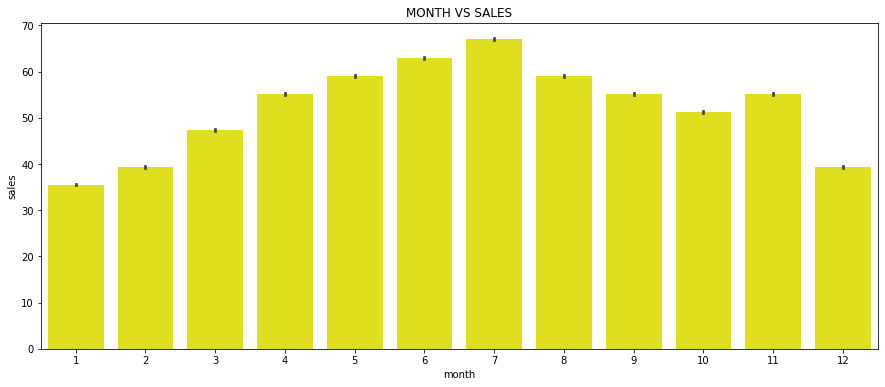

In [64]:
 # plotting the month vs sales
plt.figure(figsize=(15, 6))
sns.barplot(data=new_df, x="month", y="sales" ,color='yellow').set(title='MONTH VS SALES')

From the above plot we can clearly see that there is an increase in sales from the month of janaury till july, after that there is slight downscale and again a peak in the month of november. so seasonality exists.

[Text(0.5, 1.0, 'YEAR VS SALES')]

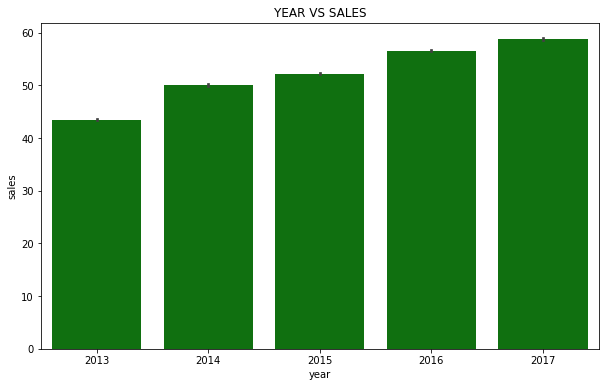

In [65]:
 # plotting the Year vs sales
plt.figure(figsize=(10, 6))
sns.barplot(data=new_df, x="year", y="sales" ,color='green').set(title='YEAR VS SALES')

from the above plot we can clearly see that there is an constant increase in sales

[Text(0.5, 1.0, 'QUARTER vs SALES')]

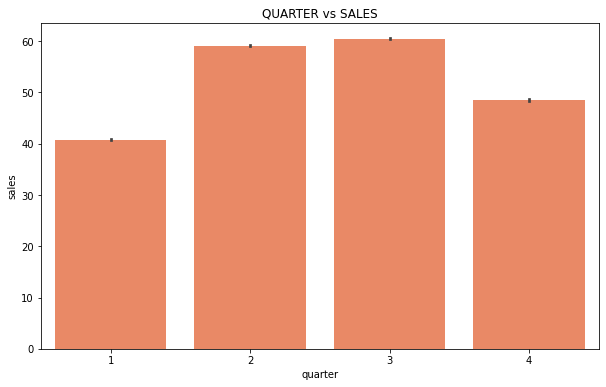

In [66]:
# Plotting quarter vs sales
plt.figure(figsize=(10, 6))
sns.barplot(data=new_df, x="quarter", y="sales", color='coral').set(title='QUARTER vs SALES')

according to the plot we can clearly see that quarter 2 and 3 has higher sales comparing to quarter 1 and 4.

[Text(0.5, 1.0, 'WEEK OF YEAR VS SALES')]

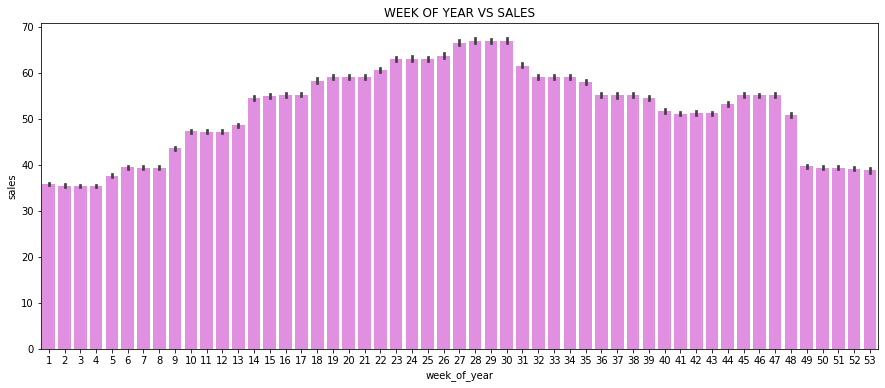

In [67]:
## plotting weak vs sales

plt.figure(figsize=(15, 6))
sns.barplot(data=new_df, x="week_of_year", y="sales", color='violet').set(title='WEEK OF YEAR VS SALES')

There is a constant increase in sales till week 31, after that sales have been constantly downscaling. we can clearly see a trend over there. 

[Text(0.5, 1.0, 'DAY OF WEEK VS SALES')]

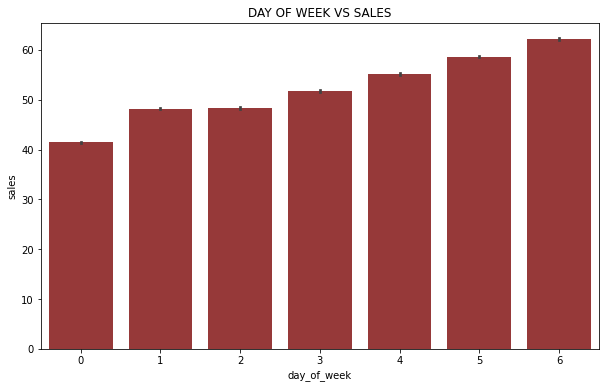

In [68]:
# plot for each day in the week
plt.figure(figsize=(10, 6))
sns.barplot(data=new_df, x="day_of_week", y="sales", color='Brown').set(title='DAY OF WEEK VS SALES')

day 1 to day 7 there is a increasing trend over there.

[Text(0.5, 1.0, 'WEEK OF YEAR VS SALES')]

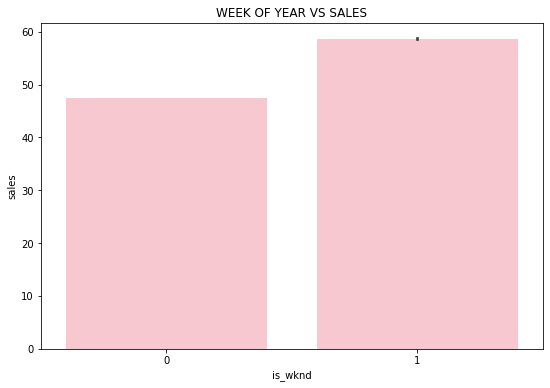

In [74]:
plt.figure(figsize=(9, 6))
sns.barplot(data=new_df, x="is_wknd", y="sales", color='pink').set(title='WEEK OF YEAR VS SALES')

the sales in weekend is higher than weekdays

In [75]:
data_week = df.groupby(['item','date'])['sales'].sum()

In [76]:
data_week.head()

item  date      
1     2013-01-01    133
      2013-01-02     99
      2013-01-03    127
      2013-01-04    145
      2013-01-05    149
Name: sales, dtype: int64

In [77]:
# aggregating the items and printing the sales sum on descending order
items = new_df.groupby(["item"]).agg({  "sales"   : "sum"}).reset_index().sort_values(by='sales',ascending=False)
items.head()

,item,sales
14,15,1607442
27,28,1604713
12,13,1539621
17,18,1538876
24,25,1473334


[Text(0.5, 1.0, 'ITEMS VS SALES')]

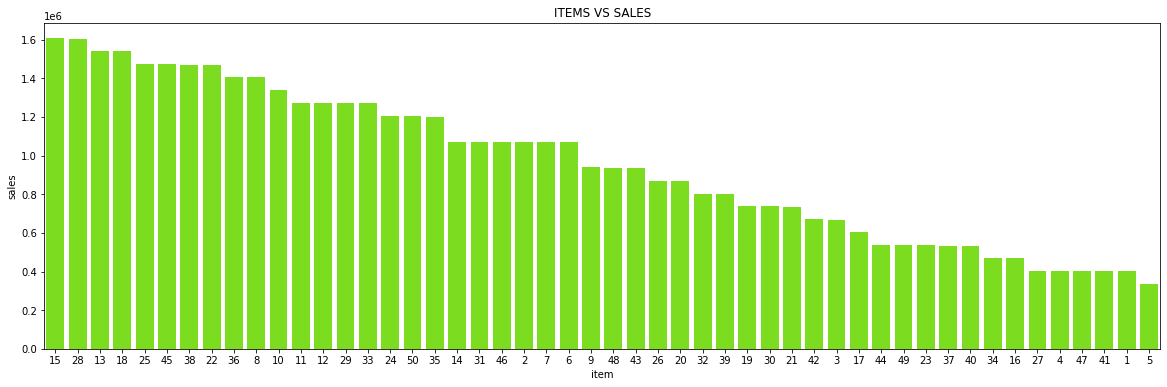

In [78]:
# plotting the item vs sales
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(data=items, x="item", y="sales",color='lawngreen', order=items.sort_values('sales', ascending=False).item).set(title='ITEMS VS SALES')

In [81]:
# calculating the sum of sales for each item in 3 month level
quarterly_sales = []
for item in range(1,51):
  ts = pd.Timestamp('2013-01-01')
  while(ts <= pd.Timestamp("2017-10-3")):
    d4 = dict()
    d4['item'] = item
    d4['date'] = ts
    d4['quarterly_sales'] = data_week.loc[item, ts:ts+pd.DateOffset(days = 90)].sum()
    quarterly_sales.append(d4)
    ts +=pd.DateOffset(days = 7)

In [82]:
# creating a dataframe and adding generated values 
df_week = pd.DataFrame(quarterly_sales)
df_week.head()

,item,date,quarterly_sales
0,1,2013-01-01,12981
1,1,2013-01-08,13542
2,1,2013-01-15,14030
3,1,2013-01-22,14500
4,1,2013-01-29,15003


In [83]:
df_week['year'] = df_week['date'].dt.year # year column

df_week['day'] = df_week['date'].dt.day # day of the month  column

df_week['quarter'] = df_week['date'].dt.quarter # quarter of the year column

df_week['month'] = df_week['date'].dt.month 

In [84]:
# printing the shape of the new dataframe
df_week.shape


(12450, 7)

In [85]:
df_week.head()

,item,date,quarterly_sales,year,day,quarter,month
0,1,2013-01-01,12981,2013,1,1,1
1,1,2013-01-08,13542,2013,8,1,1
2,1,2013-01-15,14030,2013,15,1,1
3,1,2013-01-22,14500,2013,22,1,1
4,1,2013-01-29,15003,2013,29,1,1


<AxesSubplot:xlabel='date'>

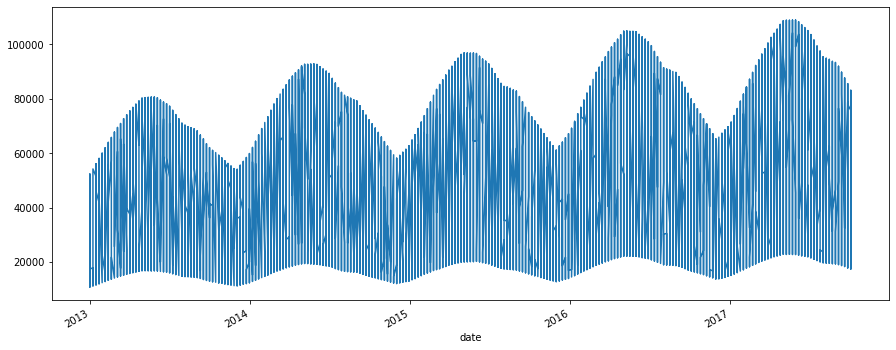

In [86]:
# checking the trend of the data using line plot
df_week.set_index('date').quarterly_sales.plot(figsize=(15, 6))

In [90]:
df_week.head()

,item,date,quarterly_sales,year,day,quarter,month
0,1,2013-01-01,12981,2013,1,1,1
1,1,2013-01-08,13542,2013,8,1,1
2,1,2013-01-15,14030,2013,15,1,1
3,1,2013-01-22,14500,2013,22,1,1
4,1,2013-01-29,15003,2013,29,1,1


### MODEL VALIDATION

In [91]:

df_copy = df_week.copy()
df_copy = pd.get_dummies(df_week['item'])


# we cannot perform slicing on numerical column names. pandas doesn't allow as to do that
# pandas provide inbuild function called add_prefix to convert column nmaes to objects
df_copy = df_copy.add_prefix('item_')


df_model = pd.concat([df_week, df_copy], axis=1)
df_model.head()

,item,date,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,1,2013-01-01,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2013-01-08,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2013-01-15,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2013-01-22,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2013-01-29,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
df_model.drop(['date', 'item'], axis=1, inplace=True)

In [93]:
df_model.head()

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50
0,12981,2013,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13542,2013,8,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,14030,2013,15,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,14500,2013,22,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,15003,2013,29,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
# slicing the dataset into train, validation, and test based on year feature
train = df_model.loc[(df_model["year"] <=2015)]
val = df_model.loc[(df_model["year"] == 2016)]
test = df_model.loc[(df_model["year"] == 2017)]

In [95]:

X_train = train.drop(columns = ['quarterly_sales'])
Y_train = train['quarterly_sales']

val_train = val.drop(columns = ['quarterly_sales'])
val_test = val['quarterly_sales']

x_test = test.drop(columns = ['quarterly_sales'])
y_test = test['quarterly_sales']

In [96]:
# checking the shape of the train and test data
print('shape of X_train : {}'.format(X_train.shape))
print('shape of Y_train : {}'.format(Y_train.shape))
print()
print('shape of val_train : {}'.format(val_train.shape))
print('shape of val_test : {}'.format(val_test.shape))
print()
print('shape of X_test : {}'.format(x_test.shape))
print('shape of y_test : {}'.format(y_test.shape))

shape of X_train : (7850, 54)
shape of Y_train : (7850,)

shape of val_train : (2600, 54)
shape of val_test : (2600,)

shape of X_test : (2000, 54)
shape of y_test : (2000,)


In [97]:
#hyper parameters for lightGBM
lgbm_params ={ "num_leaves": [10,15,20,30],
              "learning_rate": [0.1, 0.05, 0.02],
              "colsample_bytree":[0.5, 0.8, 1.0],
              "max_depth": [5, 7, 10, 20],
             }

In [98]:
# fitting the model
model = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)
rsearch2 = RandomizedSearchCV(model, lgbm_params, cv=tscv, verbose = True, n_jobs = -1).fit( X_train, Y_train )

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [99]:
# Best Parameters
rsearch2.best_params_

{'num_leaves': 30,
 'max_depth': 20,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5}

In [100]:
# Using the above best parameters of randomized search cv we can give to lightGBM model
parameters = {'metric': 'root_mean_squared_error',
              'boosting': 'gbdt',
              'num_leaves': 20,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'max_depth': 20,
              'learning_rate': 0.05,
              'verbose': -1,
              'colsample_bytree':0.8
             }

In [101]:
# loading the dataset into model for training
lgbtrain = lgb.Dataset(data=X_train, label=Y_train)

# loading the validation dataset
lgbval = lgb.Dataset(data=val_train, label=val_test)

In [102]:
# training the model with train and validation dataset with parameter
# using the number of bossting rounds 1000 and stop at maximum 50% more in  early stopping round
model_lgbm = lgb.train(parameters,
                            lgbtrain,
                            valid_sets=lgbval,
                            num_boost_round=2000,
                            early_stopping_rounds=50)

[1]	valid_0's rmse: 23429.5
Training until validation scores don't improve for 50 rounds
[2]	valid_0's rmse: 23138.5
[3]	valid_0's rmse: 22716.1
[4]	valid_0's rmse: 22282.8
[5]	valid_0's rmse: 21854.7
[6]	valid_0's rmse: 21550.7
[7]	valid_0's rmse: 21219.5
[8]	valid_0's rmse: 20831.5
[9]	valid_0's rmse: 20505.5
[10]	valid_0's rmse: 20160
[11]	valid_0's rmse: 19820.1
[12]	valid_0's rmse: 19526.5
[13]	valid_0's rmse: 19228.5
[14]	valid_0's rmse: 18902.7
[15]	valid_0's rmse: 18618.4
[16]	valid_0's rmse: 18354.5
[17]	valid_0's rmse: 18077.3
[18]	valid_0's rmse: 17814.3
[19]	valid_0's rmse: 17601.3
[20]	valid_0's rmse: 17303.5
[21]	valid_0's rmse: 17037
[22]	valid_0's rmse: 16783.3
[23]	valid_0's rmse: 16553
[24]	valid_0's rmse: 16333.5
[25]	valid_0's rmse: 16126.1
[26]	valid_0's rmse: 15899.2
[27]	valid_0's rmse: 15697.2
[28]	valid_0's rmse: 15480.1
[29]	valid_0's rmse: 15240.8
[30]	valid_0's rmse: 15001.8
[31]	valid_0's rmse: 14797.3
[32]	valid_0's rmse: 14578.4
[33]	valid_0's rmse: 14434

[348]	valid_0's rmse: 4580.62
[349]	valid_0's rmse: 4580.37
[350]	valid_0's rmse: 4578.89
[351]	valid_0's rmse: 4578.54
[352]	valid_0's rmse: 4576.53
[353]	valid_0's rmse: 4574.28
[354]	valid_0's rmse: 4573.37
[355]	valid_0's rmse: 4571.98
[356]	valid_0's rmse: 4570.97
[357]	valid_0's rmse: 4569.14
[358]	valid_0's rmse: 4568.15
[359]	valid_0's rmse: 4567.64
[360]	valid_0's rmse: 4565.78
[361]	valid_0's rmse: 4565.81
[362]	valid_0's rmse: 4566.23
[363]	valid_0's rmse: 4565.27
[364]	valid_0's rmse: 4565.66
[365]	valid_0's rmse: 4566.8
[366]	valid_0's rmse: 4567.32
[367]	valid_0's rmse: 4568.13
[368]	valid_0's rmse: 4568.6
[369]	valid_0's rmse: 4568.49
[370]	valid_0's rmse: 4567.26
[371]	valid_0's rmse: 4566.42
[372]	valid_0's rmse: 4565.6
[373]	valid_0's rmse: 4565.39
[374]	valid_0's rmse: 4564.46
[375]	valid_0's rmse: 4564.14
[376]	valid_0's rmse: 4564.3
[377]	valid_0's rmse: 4563.07
[378]	valid_0's rmse: 4563.14
[379]	valid_0's rmse: 4561.89
[380]	valid_0's rmse: 4561.78
[381]	valid_0'

[718]	valid_0's rmse: 4434.74
[719]	valid_0's rmse: 4434.51
[720]	valid_0's rmse: 4434.41
[721]	valid_0's rmse: 4434.18
[722]	valid_0's rmse: 4434.35
[723]	valid_0's rmse: 4434.72
[724]	valid_0's rmse: 4434.7
[725]	valid_0's rmse: 4434.94
[726]	valid_0's rmse: 4435.91
[727]	valid_0's rmse: 4435.82
[728]	valid_0's rmse: 4435.83
[729]	valid_0's rmse: 4435.56
[730]	valid_0's rmse: 4435.18
[731]	valid_0's rmse: 4435.45
[732]	valid_0's rmse: 4435.43
[733]	valid_0's rmse: 4435.4
[734]	valid_0's rmse: 4435.43
[735]	valid_0's rmse: 4435.87
[736]	valid_0's rmse: 4436.09
[737]	valid_0's rmse: 4435.96
[738]	valid_0's rmse: 4436.06
[739]	valid_0's rmse: 4436.08
[740]	valid_0's rmse: 4435.48
[741]	valid_0's rmse: 4436.59
[742]	valid_0's rmse: 4437.4
[743]	valid_0's rmse: 4437.92
[744]	valid_0's rmse: 4438.8
[745]	valid_0's rmse: 4439.06
[746]	valid_0's rmse: 4439.8
[747]	valid_0's rmse: 4440.35
[748]	valid_0's rmse: 4440.84
[749]	valid_0's rmse: 4441.13
[750]	valid_0's rmse: 4440.8
[751]	valid_0's 

In [103]:
# predicting the values for training and validtion
y_train_pred = model_lgbm.predict(X_train) 
y_valid_pred = model_lgbm.predict(val_train)

In [104]:
# printing the accuacy using the r2_score 
print("r2_score Train: {:.4f}\nr2_score Valid: {:.4f}".format(r2_score(Y_train, y_train_pred),
                                                    r2_score(val_test, y_valid_pred)))

r2_score Train: 0.9987
r2_score Valid: 0.9617


Text(0, 0.5, 'Feature Importance Score')

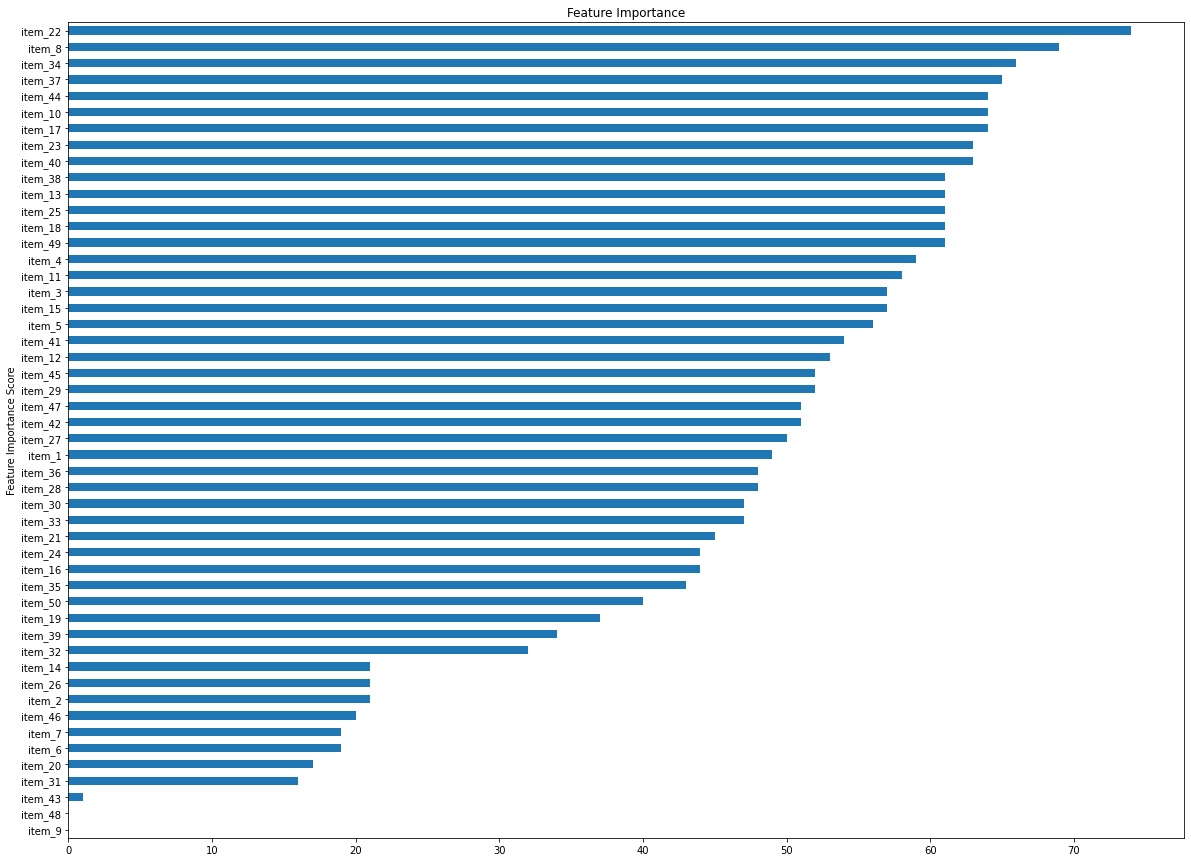

In [105]:
# mapping the feature importance
predictors = [x for x in X_train.columns]
feat_imp = pd.Series(rsearch2.best_estimator_.feature_importances_, predictors).sort_values(ascending=True)
feat_imp = feat_imp[0:50]
plt.rcParams['figure.figsize'] = 20, 15
feat_imp.plot(kind='barh', title='Feature Importance')
plt.ylabel('Feature Importance Score')

In [106]:
#predicting for the test data 
predict = model_lgbm.predict(x_test)

In [107]:
# predictions
predict

array([14114.29106398, 15543.62417863, 16335.09210268, ...,
       58428.98781475, 57844.47988395, 54288.31917514])

In [108]:
# Checking the R2 value
r2_score(y_test, predict)

0.9143382899033767

In [109]:
df1 = test

In [110]:
# we are converting this values from float to int as sales are in int datatype
p = predict.astype(int) 

# appending the values to dataframe
df1['predict_sales'] = p 

In [111]:
# printing the dataframe
df1

,quarterly_sales,year,day,quarter,month,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,predict_sales
209,17715,2017,3,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14114
210,18366,2017,10,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15543
211,18990,2017,17,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16335
212,19656,2017,24,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17534
213,20344,2017,31,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12445,68007,2017,5,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,60059
12446,66445,2017,12,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,59473
12447,64902,2017,19,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,58428
12448,63360,2017,26,3,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,57844


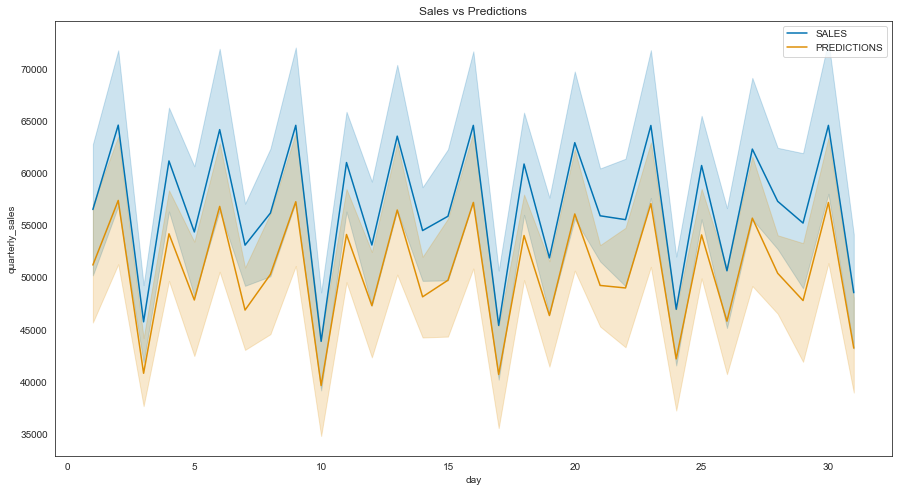

In [118]:
plt.figure(figsize=(15, 8))
plt.title("Sales vs Predictions")
sns.set_palette("colorblind")


sns.lineplot( x='day', y='quarterly_sales', data=df1,label='SALES' )
sns.lineplot( x='day', y='predict_sales', data=df1, label='PREDICTIONS' )

plt.show()